In [1]:
%matplotlib inline
import h5py
import numpy as np
from libero.lifelong.datasets import *
from libero.libero.utils.dataset_utils import get_dataset_info
from IPython.display import HTML
import imageio
from libero.libero import benchmark, get_libero_path, set_libero_default_path
import os
from termcolor import colored
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
from libero.lifelong.models import *
from libero.lifelong.utils import *
from lora_parts.policy import *
from easydict import EasyDict
import yaml
from omegaconf import OmegaConf

In [2]:
import json

with open('./config.json', 'rb') as f:
    adapt_config = json.load(f)
    f.close()

In [3]:

adapt_config = OmegaConf.to_yaml(adapt_config)
adapt_config = EasyDict(yaml.safe_load(adapt_config))

In [4]:
policy_type = 'LoraBCTPolicy'
lora_model_path = './meta_params_task_5.pth'
model_path = '/home/ruiqi/projects/meta_adapt/scripts/experiments/LIBERO_OBJECT/PreTrainMultitask/BCTransformerPolicy_seed10000/run_003/multitask_model.pth'


In [5]:
checkpoint = torch.load(model_path)
sd = checkpoint['state_dict']
cfg = checkpoint['cfg']
cfg.adaptation = adapt_config

control_seed(adapt_config.seed)
cfg.folder = get_libero_path("datasets")
cfg.bddl_folder = get_libero_path("bddl_files")
cfg.init_states_folder = get_libero_path("init_states")
model = get_policy_class(policy_type)(cfg, cfg.shape_meta)
model.load_state_dict(sd, strict=False)
lora_sd = torch.load(lora_model_path)
model.load_state_dict(lora_sd, strict=False)
TASK_SUITE = cfg['task_creation']['task_suite']

In [6]:
lora_sd.keys()

dict_keys(['temporal_transformer.layers.0.1.lora_q.weight', 'temporal_transformer.layers.0.1.lora_q.bias', 'temporal_transformer.layers.0.1.lora_q.lora_A', 'temporal_transformer.layers.0.1.lora_q.lora_B', 'temporal_transformer.layers.0.1.lora_v.weight', 'temporal_transformer.layers.0.1.lora_v.bias', 'temporal_transformer.layers.0.1.lora_v.lora_A', 'temporal_transformer.layers.0.1.lora_v.lora_B', 'temporal_transformer.layers.0.3.lora_1.weight', 'temporal_transformer.layers.0.3.lora_1.bias', 'temporal_transformer.layers.0.3.lora_1.lora_A', 'temporal_transformer.layers.0.3.lora_1.lora_B', 'temporal_transformer.layers.0.3.lora_2.weight', 'temporal_transformer.layers.0.3.lora_2.bias', 'temporal_transformer.layers.0.3.lora_2.lora_A', 'temporal_transformer.layers.0.3.lora_2.lora_B', 'temporal_transformer.layers.1.1.lora_q.weight', 'temporal_transformer.layers.1.1.lora_q.bias', 'temporal_transformer.layers.1.1.lora_q.lora_A', 'temporal_transformer.layers.1.1.lora_q.lora_B', 'temporal_transform

In [7]:
benchmark_instance = benchmark.get_benchmark_dict()["libero_object"]()

[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [8]:
bddl_files_default_path = get_libero_path("bddl_files")

In [9]:
descriptions = []
for i in range(10):
    descriptions.append(benchmark_instance.get_task(i).language)


In [10]:
task_embs = get_task_embs(cfg, descriptions)


# get dataset

In [11]:
def get_emb(task_i_dataset, task_id):
    data = {}
    data['task_emb'] = []
    data['obs'] = {}
    data['obs']['agentview_rgb'] = []
    data['obs']['eye_in_hand_rgb'] = []
    data['obs']['gripper_states'] = []
    data['obs']['joint_states'] = []

    for demo in task_i_dataset.demos:
        start_id = task_i_dataset._demo_id_to_start_indices[demo]
        obs = task_i_dataset[start_id]['obs']
        data['task_emb'].append(task_embs[task_id])
        for k in obs.keys():
            data['obs'][k].append(torch.from_numpy(obs[k]))

    data['task_emb'] = torch.stack(data['task_emb'], dim=0)
    for k in data['obs'].keys():
        data['obs'][k] = torch.stack(data['obs'][k], dim=0)

    x = model.spatial_encode(data)
    x = model.temporal_encode(x)
    return data, x.squeeze(1).detach().numpy()


In [12]:
all_task_data_emb = []
all_task_data = []
for task_id in range(6):
    task_dataset, shape_meta = get_dataset(
        dataset_path=os.path.join(
            cfg.folder, benchmark_instance.get_task_demonstration(task_id)
        ),
        obs_modality=cfg.data.obs.modality,
        initialize_obs_utils=(task_id == 0),
        seq_len=1,
    )
    data, emb = get_emb(task_dataset, task_id)
    all_task_data.append(data)
    all_task_data_emb.append(emb)




============= Initialized Observation Utils with Obs Spec =============

using obs modality: rgb with keys: ['agentview_rgb', 'eye_in_hand_rgb']
using obs modality: depth with keys: []
using obs modality: low_dim with keys: ['joint_states', 'gripper_states']
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 2826.31it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 2523.16it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 1868.39it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 2981.53it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 2652.81it/s]
SequenceDataset: loading dataset into memory...
100%|██████████| 50/50 [00:00<00:00, 1726.52it/s]


In [13]:
labels = []
for i in range(len(all_task_data_emb)):
    labels = labels + [i for _ in range(len(all_task_data_emb[i]))]

In [14]:
all_task_data_emb[0].shape

(50, 64)

In [15]:
pre_tsne_x = np.concatenate(all_task_data_emb, axis=0)
pre_tsne_x.shape

(300, 64)

# t-sne embedding visualization

In [16]:
from sklearn.manifold import TSNE

In [17]:
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(pre_tsne_x)
X_embedded.shape

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(300, 2)

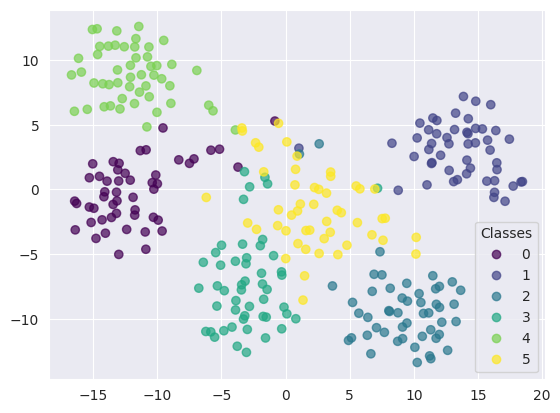

In [18]:
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', alpha=0.7)
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")


# attention maps with perturbation 

In [18]:
from libero.lifelong.models.bc_transformer_policy import PerturbationAttention

In [19]:
type(model.image_encoders['agentview_rgb']['encoder'])

libero.lifelong.models.modules.rgb_modules.ResnetEncoder

In [20]:
pert_model = PerturbationAttention(model.image_encoders['agentview_rgb']['encoder'])

In [21]:
data0 = all_task_data[0]
data0['obs']['agentview_rgb'] = data0['obs']['agentview_rgb'][0]
data0['obs']['agentview_rgb'].shape

torch.Size([1, 3, 128, 128])

In [22]:
att = pert_model(data0)

In [28]:
att.shape

(1, 1, 128, 128)

In [33]:
max(att[0,0].reshape(1,-1)[0])

0.93847656

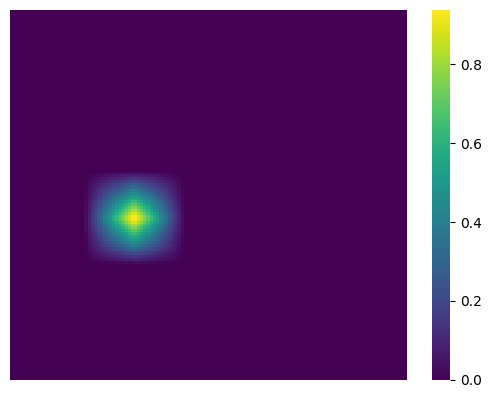

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create some data


# Create the heatmap
sns.heatmap(att[0,0], cmap='viridis')


plt.axis('off')
# Show the plot
plt.show()